In [1]:
from hamilton_ice.pipeline import get_func_args, object_io_nodes, build_pipeline
from hamilton_ice.io.artifact import artifact
from hamilton_ice.io.pandas import pandas_csv_source, pandas_msgpack
from hamilton_ice.io.dummy import dummy
from hamilton_ice.util.graphviz import dag_plot
import pandas as pd
import numpy as np
import random
import torch
from dataclasses import dataclass
from hamilton_ice.util.graphviz import dag_plot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



#Questions
* Use overrides instead of partial results
* Feature engineering is shared through module
* How to seperate code into docker containers for pyspark and pytorch
    * @config.when
    * module separation
    * all in one
* Rerun the dag for each epoch

In [6]:
validation = None

@dataclass
class Config:
    observed_size = 0
    reservoir_size = 50
    random_seed = 42
    output_field = "Survived"

@dataclass
class TrainingValidationMinibatch:
    train : pd.DataFrame
    validation : pd.DataFrame
        
@dataclass
class AnnotatedLoss:
    loss : float
    validation_loss : float

class Titanic:
    @artifact
    def params():
        return {}
    
    @artifact
    def config():
        return Config()
    
    @pandas_csv_source
    def minibatch(config):
        return "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"    
        

        
    @dummy
    def normalized_data(minibatch, config):
        dat = minibatch
        normalized = pd.DataFrame({
            "Survived" : dat["Survived"].astype(float),
            "NormPclass" : dat["Pclass"]/3,
            "MaleSex" : (dat["Sex"] == "male").astype(float),
            "FemaleSex" : (dat["Sex"] == "female").astype(float),
            "NormAge" : dat["Age"] / 100,
            "NormSibSp" :dat["SibSp"] /10,
            "NormParch" : dat["Parch"]/10,
            "NormFare" : dat["Fare"]/1000,
            "Embarked_C" : (dat["Embarked"] == "C").astype(float),
            "Embarked_S" : (dat["Embarked"] == "S").astype(float),
            "Embarked_Q" : (dat["Embarked"] == "Q").astype(float),
        })
        mean_value = normalized["NormAge"].mean(skipna=True)
        normalized["NormAge"].fillna(mean_value, inplace=True)
        yield normalized
    
    @dummy
    def annotated_data(normalized_data, config):
        np.random.seed(config.random_seed)
        msk = np.random.rand(len(normalized_data)) < 0.8
        normalized_data["train"] = msk
        normalized_data["eval"] = ~msk
        yield normalized_data
    
    @dummy    
    def evaluate(annotated_data):  
        yield annotated_data[annotated_data["eval"]]
    
    
    @dummy                                 
    def annotated_train(annotated_data, config):
        train = annotated_data[annotated_data["train"]].drop(["train", "eval"], axis = 1).copy()
        
        global validation
        
        k = random.randint(0, config.reservoir_size)
        if validation is None:
            validation = train.copy()
        elif k == 1:
            # swap an element with reservoir
            val_idx = random.choice(validation.index)
            train_idx = random.choice(train.index)
            validation.loc[val_idx] = train.loc[train_idx]

        yield TrainingValidationMinibatch(train=train, validation=validation)
        
    
    @artifact
    def optimizer(model):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
        return optimizer
    
    @artifact
    def criterion(config):
        return torch.nn.BCELoss() 
    
    
    
    @dummy
    def train(annotated_train, model, optimizer, criterion):
        optimizer.zero_grad()
        train = annotated_train.train.drop(["Survived"], 1).to_numpy()
        train_features = torch.tensor(train)
        train_outputs = model(train_features.float())
        train_labels = torch.tensor(annotated_train.train["Survived"].to_numpy())

        validation = annotated_train.validation.drop(["Survived"], 1).to_numpy()
        validation_features = torch.tensor(validation)
        validation_outputs = model(validation_features.float())
        validation_labels = torch.tensor(annotated_train.validation["Survived"].to_numpy())
        loss = criterion(
            train_outputs.flatten().float(), 
            train_labels.flatten().float()
            )

        validation_loss = criterion(
            validation_outputs.flatten().float(), 
            validation_labels.flatten().float()
            )

        loss.backward() 
        optimizer.step()
      
        yield AnnotatedLoss(loss = loss.item(), validation_loss = validation_loss.item())
    
    @artifact
    def model (config, annotated_train):
        n_features = annotated_train.train.drop(["Survived"], 1).shape[1]
        model = torch.nn.Sequential(torch.nn.Linear(n_features, 50),
                            torch.nn.ReLU(),
                            torch.nn.Linear(50, 1),
                            torch.nn.Sigmoid())
        return model
        
build_pipeline(Titanic)

In [9]:
epochs = []
for epoch in range(0,1000):
    if epoch % 100 == 0:
        print(f"epoch: {epoch}")
    for aloss in Titanic.train.generator():
        epochs.append(aloss.__dict__)


epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900


<Axes: >

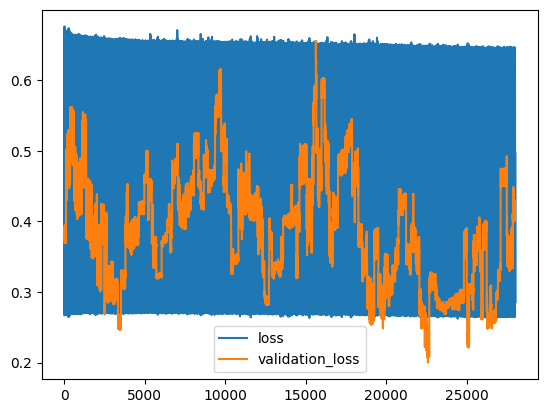

In [10]:
pd.DataFrame.from_records(epochs).plot()

In [ ]:
model = Titanic.model.artifact()
model

In [ ]:
dag_plot(Titanic)